### Calcification and alkalinity validation notebook

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster

import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
style.use('ggplot')

Cannot write to data cache folder '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


In [2]:
case = 'cesm22cocco.G1850ECOIAF.T62_g17.003'
#path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1'
path = '/glade/campaign/cgd/oce/projects/besome/cesm-cases/'+case+'/ocn/proc/tseries/month_1'

In [3]:
variables = ['CaCO3_PROD_zint','coccoCaCO3','ALK'] #'spChl','diatChl','diazChl
coords = {'x':'TLONG','y':'TLAT'}

In [4]:
keepthese = ['z_t','z_t_150m','time_bound','TAREA','REGION_MASK', 'time'] + variables

In [5]:
%%time

ds_list = []

print(f'reading {case}')

ds = xr.Dataset()

for v in variables:
    
    print(v)
    
    #files = sorted(glob(f'{path}/{case}.pop.h.{v}.000101-006212.nc'))       #if just wanting first IAF
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.012501-018612.nc')) 
    files = files+ sorted(glob(f'{path}/{case}.pop.h.{v}.018701-024812.nc')) 
    files = files + sorted(glob(f'{path}/{case}.pop.h.{v}.024901-031012.nc')) #5th IAF
    #files = sorted(glob(f'{path}/{case}.pop.h.{v}.??????-??????.nc'))     
    #print(files)
    
    #dsv = xr.open_mfdataset(files, decode_times=True, decode_coords=False)
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading cesm22cocco.G1850ECOIAF.T62_g17.003
CaCO3_PROD_zint
coccoCaCO3
ALK
CPU times: user 1.43 s, sys: 185 ms, total: 1.62 s
Wall time: 3.41 s


In [6]:
files

['/glade/campaign/cgd/oce/projects/besome/cesm-cases/cesm22cocco.G1850ECOIAF.T62_g17.003/ocn/proc/tseries/month_1/cesm22cocco.G1850ECOIAF.T62_g17.003.pop.h.ALK.012501-018612.nc',
 '/glade/campaign/cgd/oce/projects/besome/cesm-cases/cesm22cocco.G1850ECOIAF.T62_g17.003/ocn/proc/tseries/month_1/cesm22cocco.G1850ECOIAF.T62_g17.003.pop.h.ALK.018701-024812.nc',
 '/glade/campaign/cgd/oce/projects/besome/cesm-cases/cesm22cocco.G1850ECOIAF.T62_g17.003/ocn/proc/tseries/month_1/cesm22cocco.G1850ECOIAF.T62_g17.003.pop.h.ALK.024901-031012.nc']

In [7]:
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

In [8]:
tlen=len(ds.time)
#resetting the time variable so that it's a mean of the time bounds
ds["time"] = ds.time_bound.compute().mean(dim="d2")

In [9]:
ds_annmean = xr.Dataset()
for v in variables:
    ds_annmean[v] = ds[v].isel(time=slice(-120,tlen)).mean(dim='time')

In [10]:
#just getting this for the coords (that don't have nans)
file = '/glade/work/kristenk/GLODAPv2_regridded/glodap_pop_grid/GLODAP_POPgrid_v2.nc'
ds_glodap = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_glodap['z_t']=ds.z_t
lons=ds_glodap.TLONG
lats=ds_glodap.TLAT
area=ds_glodap.TAREA
depths=ds_glodap.z_t * 0.01

In [11]:
ALK_diff = ds_annmean.ALK - ds_glodap.ALK

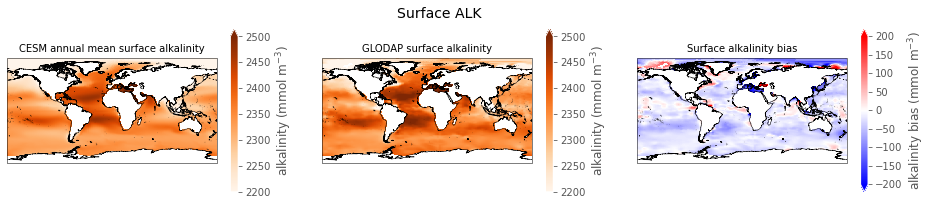

In [12]:
fig = plt.figure(figsize=(16,3))
plt.suptitle('Surface ALK', fontsize=14)

####################SiO3
#---- CESM panel
ax = fig.add_subplot(1,3,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface alkalinity', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds_annmean.ALK.isel(z_t=0), 
                  vmin=2200, vmax=2500, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='alkalinity (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(1,3,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('GLODAP surface alkalinity', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_glodap.ALK.isel(z_t=0), 
                  vmin=2200, vmax=2500, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='alkalinity (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(1,3,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface alkalinity bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 ALK_diff.isel(z_t=0), 
                  vmin=-200, vmax=200, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='alkalinity bias (mmol m$^{-3}$)')

In [13]:
#get original glodap data
ds_glodap2 = xr.open_dataset('/glade/work/kristenk/GLODAPv2_regridded/TAlk_GLODAP_normal1deg_33depths.nc',decode_times=False,decode_coords=False)

In [14]:
cesm_depths = ds_annmean.z_t * 0.01 #converting from cm to m
glodap_depths = ds_glodap2.depth_surface

In [15]:
area = xr.DataArray(np.zeros([180,360]), dims=('lat','lon'))
j=0
for lat in ds_glodap2.lat.values:
    
    pi     =    3.14159265359
    radius = 6378.137

    deg2rad = pi / 180.0

    resolution_lat =1.
    resolution_lon =1.

    elevation = deg2rad * (lat + (resolution_lat / 2.0))

    deltalat = deg2rad * resolution_lon
    deltalon = deg2rad * resolution_lat

    area[j,:] = (2.0*radius**2*deltalon*np.cos(elevation)*np.sin((deltalat/2.0)))
    
    j = j + 1

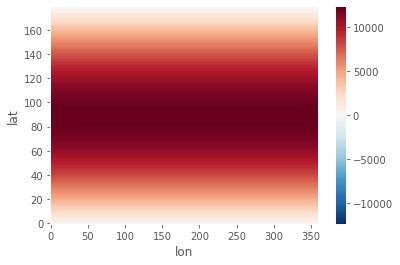

In [16]:
area.plot()

In [17]:
ds_glodap2['area']=area

In [18]:
ds_glb_glodap = xr.Dataset({v: ds_glodap2[v] for v in ['depth_surface']})
ds_glb_cesm = xr.Dataset({v: ds_annmean[v] for v in ['z_t']})
ds_glb_glodap['TAlk'] = esmlab.weighted_mean(ds_glodap2.TAlk*1.027, weights=ds_glodap2['area'], dim=['lat', 'lon']).compute()
ds_glb_cesm['ALK'] = esmlab.weighted_mean(ds_annmean['ALK'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

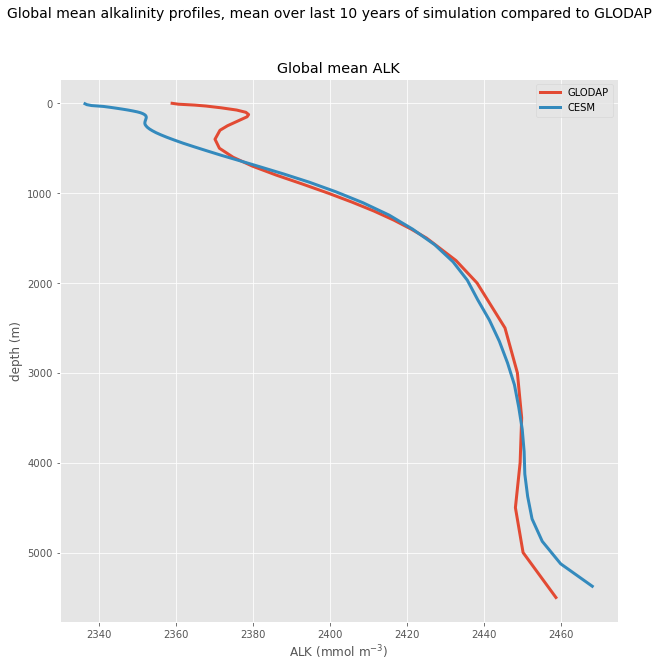

In [19]:
fig = plt.figure(figsize=(10,10))

plt.suptitle('Global mean alkalinity profiles, mean over last 10 years of simulation compared to GLODAP', fontsize=14)

ax = fig.add_subplot(1,1,1)
ax.set_title('Global mean ALK')
ax.plot(ds_glb_glodap['TAlk'].values, glodap_depths, label='GLODAP', linewidth=3)
ax.plot(ds_glb_cesm['ALK'].values, cesm_depths, label='CESM', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='ALK (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#### Let's look at drift in Alkalinity

In [20]:
ds2 = ds.isel()

In [21]:
#make a dataset with just annual means
ds_annmean_ts=ds.resample({'time':'A'}).mean(dim='time')
#ds_annmean_ts

In [22]:
#%%time
#ds_annmean_ts = ds.isel(time=(0,744)).resample({'time':'A'}).mean(dim='time').compute()

In [23]:
ds_annmean_ts

<xarray.Dataset>
Dimensions:          (nlat: 384, nlon: 320, time: 186, z_t: 60, z_t_150m: 15)
Coordinates:
  * time             (time) object 0125-12-31 00:00:00 ... 0310-12-31 00:00:00
    TLAT             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG            (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t_150m         (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * z_t              (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT              (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TAREA            (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    REGION_MASK      (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    dz               (time, z_t) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    CaCO3_PROD_zint  (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    coccoCaCO3       (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1, 15, 384, 320), meta=np.ndarray>
    ALK              (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>

In [24]:
%%time
ts_global = xr.Dataset({v: ds_annmean_ts[v] for v in ['time','z_t']})
ts_global['ALK'] = esmlab.weighted_mean(ds_annmean_ts['ALK'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

CPU times: user 7min 48s, sys: 4min 15s, total: 12min 4s
Wall time: 8min 16s


In [25]:
z_top=cesm_depths.isel(z_t=slice(0,40))
z_bottom=cesm_depths.isel(z_t=slice(40,60))
years = np.arange(len(ds_annmean_ts.time))

In [26]:
ts_global = ts_global.transpose()

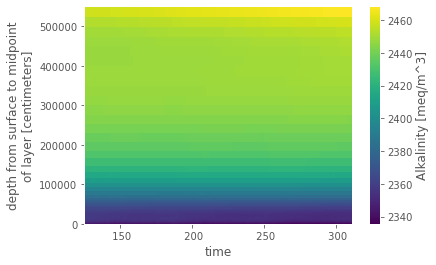

In [27]:
ts_global.ALK.plot()

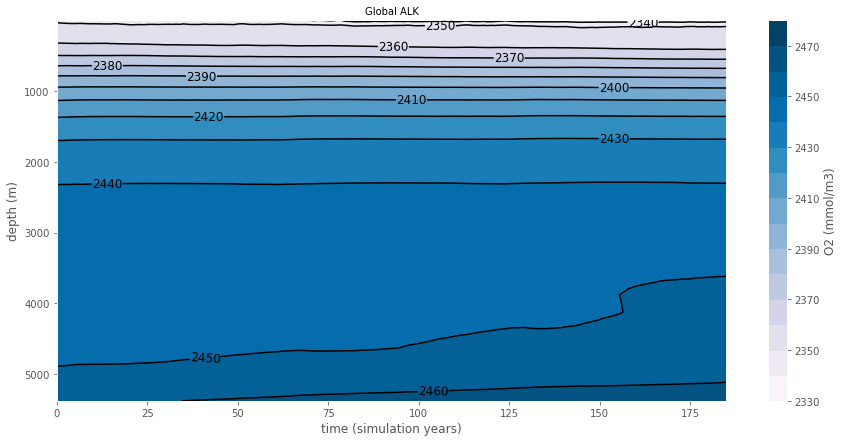

In [28]:
#this cell plots normal depth versus time plot
fig = plt.figure(figsize=(15,7))
#plt.suptitle('Atlantic', fontsize=12)
ax = fig.add_subplot(1,1,1)
ax.set_title('Global ALK', fontsize=10)
levels = ['2330','2340','2350','2360','2370','2380','2390','2400','2410','2420','2430','2440','2450','2460','2470','2480']
pc=ax.contourf(years, depths, ts_global['ALK'], levels, cmap='PuBu')
contour = plt.contour(years, cesm_depths, ts_global['ALK'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='O2 (mmol/m3)')
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

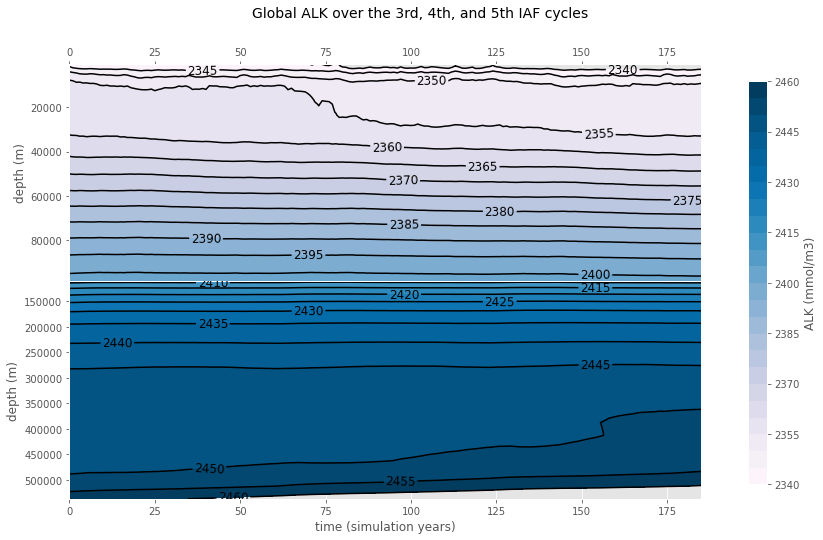

In [36]:
fig = plt.figure(figsize=(13,8))

plt.suptitle('Global ALK over the 3rd, 4th, and 5th IAF cycles', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = ['2340','2345','2350','2355','2360','2365','2370','2375','2380','2385','2390','2395','2400','2405','2410','2415','2420','2425','2430','2435','2440','2445','2450','2455','2460']
pc=ax.contourf(years, z_top, ts_global['ALK'].isel(z_t=slice(0,40)), levels, cmap='PuBu')
contour = plt.contour(years, z_top, ts_global['ALK'].isel(z_t=slice(0,40)), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, ts_global['ALK'].isel(z_t=slice(40,60)), levels, cmap='PuBu')
contour = plt.contour(years, z_bottom, ts_global['ALK'].isel(z_t=slice(40,60)), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='ALK (mmol/m3)')

In [31]:
%%time
ts_SO = xr.Dataset({v: ds_annmean_ts[v] for v in ['time','z_t']})
ts_SO['ALK'] = esmlab.weighted_mean(ds_annmean_ts['ALK'].where(ds.TLAT<-30), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

CPU times: user 7min 28s, sys: 3min 10s, total: 10min 39s
Wall time: 7min 14s


In [32]:
ts_SO = ts_SO.transpose()

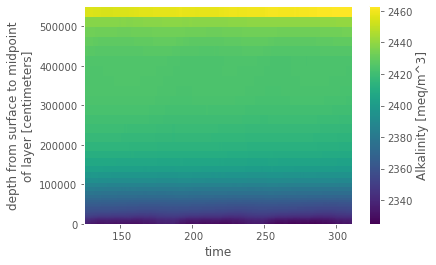

In [33]:
ts_SO.ALK.plot()

In [34]:
z_top = ts_SO.z_t.isel(z_t=slice(0,40))
z_bottom = ts_SO.z_t.isel(z_t=slice(40,60))
years = np.arange(len(ts_SO.time))

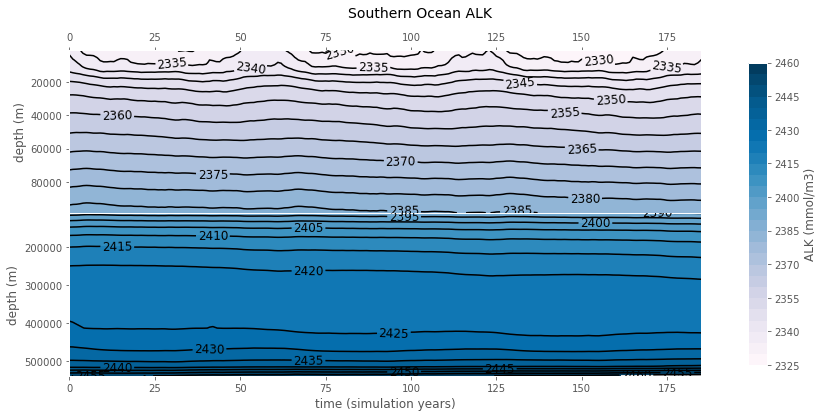

In [35]:
fig = plt.figure(figsize=(13,6))

plt.suptitle('Southern Ocean ALK', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = ['2325','2330','2335','2340','2345','2350','2355','2360','2365','2370','2375','2380','2385','2390','2395','2400','2405','2410','2415','2420','2425','2430','2435','2440','2445','2450','2455','2460']
pc=ax.contourf(years, z_top, ts_SO['ALK'].isel(z_t=slice(0,40)), levels, cmap='PuBu')
contour = plt.contour(years, z_top, ts_SO['ALK'].isel(z_t=slice(0,40)), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, ts_SO['ALK'].isel(z_t=slice(40,60)), levels, cmap='PuBu')
contour = plt.contour(years, z_bottom, ts_SO['ALK'].isel(z_t=slice(40,60)), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='ALK (mmol/m3)')